# A Transformer-based recommendation system

- **사용 데이터** : movie lens 데이터
https://grouplens.org/datasets/movielens/

- **사용 모델** : BST(Behavior Sequence Transformer) 모델

- **목표** : 영화별 사용자의 평가 예측

<br>

- **방법**
1. 사용자가 시청한 영화movie_ids -> 고정길이 시퀀스
2. 사용자가 시청한 영화에 매긴 평점 ratings -> 고정길이 시퀀스
3. 유저 정보(유저 id, 성별, 직업, 나이대)
4. 영화의 장르
5. 타겟 영화 id의 평점 예측

In [ ]:
# 필요 라이브러리 import

import os
import math
from zipfile import ZipFile
from urllib.request import urlretrieve
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import StringLookup

# 1. 데이터 불러오기 & 전처리

In [ ]:
# 유저 데이터 로드
users = pd.read_csv(
    "ml-1m/users.dat",
    sep="::",
    names=["user_id", "sex", "age_group", "occupation", "zip_code"], encoding='latin-1'
)

# 유저별 영화 평점 데이터 로드
ratings = pd.read_csv(
    "ml-1m/ratings.dat",
    sep="::",
    names=["user_id", "movie_id", "rating", "unix_timestamp"], encoding='latin-1'
)

#영화 데이터 로드
movies = pd.read_csv(
    "ml-1m/movies.dat", sep="::", names=["movie_id", "title", "genres"], encoding='latin-1'
)

C:\Users\acw64\AppData\Local\Temp\ipykernel_18348\1405511541.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  users = pd.read_csv(
C:\Users\acw64\AppData\Local\Temp\ipykernel_18348\1405511541.py:9: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  ratings = pd.read_csv(
C:\Users\acw64\AppData\Local\Temp\ipykernel_18348\1405511541.py:16: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  movies = pd.read_csv(


In [ ]:
# 데이터 전처리

users["user_id"] = users["user_id"].apply(lambda x: f"user_{x}") # 1 -> user_1로 변경
users["age_group"] = users["age_group"].apply(lambda x: f"group_{x}") # 1 ->group_1로 변경
users["occupation"] = users["occupation"].apply(lambda x: f"occupation_{x}") #1 ->occupation_1로 변경

movies["movie_id"] = movies["movie_id"].apply(lambda x: f"movie_{x}") # 1 -> movie1로 변경

ratings["movie_id"] = ratings["movie_id"].apply(lambda x: f"movie_{x}") # 1 -> movie1로 변경
ratings["user_id"] = ratings["user_id"].apply(lambda x: f"user_{x}") # 1 -> user_1로 변경
ratings["rating"] = ratings["rating"].apply(lambda x: float(x)) # 평점 실수형 변수로 변경

In [ ]:
# 영화 데이터 장르 분할

genres = [
    "Action",
    "Adventure",
    "Animation",
    "Children's",
    "Comedy",
    "Crime",
    "Documentary",
    "Drama",
    "Fantasy",
    "Film-Noir",
    "Horror",
    "Musical",
    "Mystery",
    "Romance",
    "Sci-Fi",
    "Thriller",
    "War",
    "Western",
]

print('변경 전')
display(movies.head(1))

for genre in genres:
    movies[genre] = movies["genres"].apply(
        lambda values: int(genre in values.split("|"))
    )

print('변경 후')
display(movies.head(1))

변경 전


,movie_id,title,genres
0,movie_1,Toy Story (1995),Animation|Children's|Comedy


변경 후


,movie_id,title,genres,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,movie_1,Toy Story (1995),Animation|Children's|Comedy,0,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0


# 2. 영화 평점 데이터 시퀀스 변환

평점 데이터에 존재하는 `unix_timestamp` 변수를 이용해 유저 아이디 별 평가 기록 그룹화

In [ ]:
# 기존 데이터
ratings.head(1)

,user_id,movie_id,rating,unix_timestamp
0,user_1,movie_1193,5.0,978300760


In [ ]:
# 영화 평점 데이터 유저 id 별로 그룹화 + 시간 순서대로 sorting
ratings_group = ratings.sort_values(by=["unix_timestamp"]).groupby("user_id")

# 시간 순서대로 평가 sequence 데이터프레임 생성
ratings_data = pd.DataFrame(
    data={
        "user_id": list(ratings_group.groups.keys()),
        "movie_ids": list(ratings_group.movie_id.apply(list)),
        "ratings": list(ratings_group.rating.apply(list)),
        "timestamps": list(ratings_group.unix_timestamp.apply(list)),
    }
)

In [ ]:
# 유저 id 별 평가한 영화, 평점을 시간 순으로 나타냄
ratings_data.head(3)

,user_id,movie_ids,ratings,timestamps
0,user_1,"[movie_3186, movie_1721, movie_1270, movie_102...","[4.0, 4.0, 5.0, 5.0, 3.0, 5.0, 4.0, 4.0, 5.0, ...","[978300019, 978300055, 978300055, 978300055, 9..."
1,user_10,"[movie_597, movie_858, movie_743, movie_1210, ...","[4.0, 3.0, 3.0, 4.0, 4.0, 5.0, 5.0, 5.0, 3.0, ...","[978224375, 978224375, 978224375, 978224400, 9..."
2,user_100,"[movie_260, movie_1676, movie_1198, movie_541,...","[4.0, 3.0, 4.0, 3.0, 4.0, 3.0, 1.0, 1.0, 5.0, ...","[977593595, 977593595, 977593607, 977593624, 9..."


movie id, rating 목록을 고정 길이 sequence로 분할

In [ ]:
# movie id, rating 목록을 고정 길이 sequence로 분할

sequence_length = 4 # 시퀀스 길이 = 4 (수정 가능)
step_size = 2 # 간격 사이즈 = 2 (수정 가능)


def create_sequences(values, window_size, step_size):
    sequences = []
    start_index = 0
    while True:
        end_index = start_index + window_size # start 지점 +시퀀스 길이로 end 지점 정의
        seq = values[start_index:end_index] # 시퀀스에 할당되는 값
        if len(seq) < window_size: # 할당 값이 시퀀스 길이보다 작아지기 전에 종료 -> 모든 시퀀스의 길이를 동일하게 만듦
            seq = values[-window_size:]
            if len(seq) == window_size:
                sequences.append(seq)
            break
        sequences.append(seq)
        start_index += step_size
    return sequences

# 유저별 평가 데이터의 movie id를 sequence로 분할
ratings_data.movie_ids = ratings_data.movie_ids.apply(
    lambda ids: create_sequences(ids, sequence_length, step_size)
)

# 유저별 평가 데이터의 rating를 sequence로 분할

ratings_data.ratings = ratings_data.ratings.apply(
    lambda ids: create_sequences(ids, sequence_length, step_size)
)

# time stamp는 제거
del ratings_data["timestamps"]

In [ ]:
ratings_data.head()

,user_id,movie_ids,ratings
0,user_1,"[[movie_3186, movie_1721, movie_1270, movie_10...","[[4.0, 4.0, 5.0, 5.0], [5.0, 5.0, 3.0, 5.0], [..."
1,user_10,"[[movie_597, movie_858, movie_743, movie_1210]...","[[4.0, 3.0, 3.0, 4.0], [3.0, 4.0, 4.0, 5.0], [..."
2,user_100,"[[movie_260, movie_1676, movie_1198, movie_541...","[[4.0, 3.0, 4.0, 3.0], [4.0, 3.0, 4.0, 3.0], [..."
3,user_1000,"[[movie_971, movie_260, movie_2990, movie_2973...","[[4.0, 5.0, 4.0, 3.0], [4.0, 3.0, 5.0, 5.0], [..."
4,user_1001,"[[movie_1198, movie_1617, movie_2885, movie_39...","[[4.0, 4.0, 4.0, 2.0], [4.0, 2.0, 2.0, 1.0], [..."


시퀀스와 유저 정보를 포함하는 최종 데이터셋 생성

In [ ]:
# 유저 id - 평가 영화 id(4개) 시퀀스 데이터
ratings_data_movies = ratings_data[["user_id", "movie_ids"]].explode(
    "movie_ids", ignore_index=True
)

# 유저 id - 평점(4개) 시퀀스 데이터
ratings_data_rating = ratings_data[["ratings"]].explode("ratings", ignore_index=True)

# 유저 id 별 평가 영화와 평점 시퀀스 데이터 병합
ratings_data_transformed = pd.concat([ratings_data_movies, ratings_data_rating], axis=1)
# 유저 데이터 병합 , 유저 id를 인덱스로 지정
ratings_data_transformed = ratings_data_transformed.join(
    users.set_index("user_id"), on="user_id"
)

# 영화 id 시퀀스 ','로 구분
ratings_data_transformed.movie_ids = ratings_data_transformed.movie_ids.apply(
    lambda x: ",".join(x)
)
# 영화 평점 시퀀스 ','로 구분
ratings_data_transformed.ratings = ratings_data_transformed.ratings.apply(
    lambda x: ",".join([str(v) for v in x])
)

# 우편 번호 데이터 삭제
del ratings_data_transformed["zip_code"]

# 컬럼명 변경
ratings_data_transformed.rename(
    columns={"movie_ids": "sequence_movie_ids", "ratings": "sequence_ratings"},
    inplace=True,
)

In [ ]:
display(ratings_data_transformed.head())
print('총 시퀀스 개수 : ', len(ratings_data_transformed))

,user_id,sequence_movie_ids,sequence_ratings,sex,age_group,occupation
0,user_1,"movie_3186,movie_1721,movie_1270,movie_1022","4.0,4.0,5.0,5.0",F,group_1,occupation_10
1,user_1,"movie_1270,movie_1022,movie_2340,movie_1836","5.0,5.0,3.0,5.0",F,group_1,occupation_10
2,user_1,"movie_2340,movie_1836,movie_3408,movie_1207","3.0,5.0,4.0,4.0",F,group_1,occupation_10
3,user_1,"movie_3408,movie_1207,movie_2804,movie_260","4.0,4.0,5.0,4.0",F,group_1,occupation_10
4,user_1,"movie_2804,movie_260,movie_720,movie_1193","5.0,4.0,3.0,5.0",F,group_1,occupation_10


총 시퀀스 개수 :  498623


최종 데이터의 85%를 train 데이터로, 15%를 test 데이터 분할하고 csv 파일로 저장

In [ ]:
random_selection = np.random.rand(len(ratings_data_transformed.index)) <= 0.85 # 전체 데이터의 85% 랜덤 지정
train_data = ratings_data_transformed[random_selection] # 85%의 데이터 train 데이터로 지정
test_data = ratings_data_transformed[~random_selection] # 15%의 데이터 test 데이터로 지정

#test, train 데이터 csv로 저장
train_data.to_csv("train_data.csv", index=False, sep="|", header=False)
test_data.to_csv("test_data.csv", index=False, sep="|", header=False)

메타데이터 정의

In [ ]:

# 컬럼 명 정의
CSV_HEADER = list(ratings_data_transformed.columns)

# 유저, 영화, 성별, 나이 그룹, 직업 그룹 정의
CATEGORICAL_FEATURES_WITH_VOCABULARY = {
    "user_id": list(users.user_id.unique()),
    "movie_id": list(movies.movie_id.unique()),
    "sex": list(users.sex.unique()),
    "age_group": list(users.age_group.unique()),
    "occupation": list(users.occupation.unique()),
}

# 유저 정보 - 성별, 나이, 직업
USER_FEATURES = ["sex", "age_group", "occupation"]
# 영화 정보 - 장르
MOVIE_FEATURES = ["genres"]

# 3. training과 평가를 위한 tf.data.Dataset 생성

In [ ]:
# get_dataset_from_csv 함수 생성

def get_dataset_from_csv(csv_file_path, shuffle=False, batch_size=128):
    def process(features):
        # 영화 id 시퀀스 ',' 기준으로 분할 후 tensor로 저장
        movie_ids_string = features["sequence_movie_ids"]
        sequence_movie_ids = tf.strings.split(movie_ids_string, ",").to_tensor()

        # 시퀀스 별 마지막 영화 id를 target movie로 지정 (이전 3개의 영화로 마지막 1개의 영화 예측)
        features["target_movie_id"] = sequence_movie_ids[:, -1]
        features["sequence_movie_ids"] = sequence_movie_ids[:, :-1]

        # 평점 시퀀스 ','를 기준으로 분할 후 tensor로 저장
        ratings_string = features["sequence_ratings"]
        sequence_ratings = tf.strings.to_number(
            tf.strings.split(ratings_string, ","), tf.dtypes.float32
        ).to_tensor()

        # The last rating in the sequence is the target for the model to predict.
        # 시퀀스 별 마지막 평점을 target rating으로 지정 (이전 3 평점으로 마지막 1개의 평점 예측)
        target = sequence_ratings[:, -1]
        features["sequence_ratings"] = sequence_ratings[:, :-1]

        return features, target

    # 배치 사이즈에 따른 데이터 set 지정
    dataset = tf.data.experimental.make_csv_dataset(
        csv_file_path,
        batch_size=batch_size,
        column_names=CSV_HEADER,
        num_epochs=1,
        header=False,
        field_delim="|",
        shuffle=shuffle,
    ).map(process)

    return dataset

# 4. 입력 모델 생성

In [ ]:
def create_model_inputs():
    return {
        # 유저 id layer
        "user_id": layers.Input(name="user_id", shape=(1,), dtype=tf.string),
        # 영화 id 시퀀스 layer :길이(3)
        "sequence_movie_ids": layers.Input(
            name="sequence_movie_ids", shape=(sequence_length - 1,), dtype=tf.string
        ),
        # 타겟 영화 id layer : 길이(1)
        "target_movie_id": layers.Input(
            name="target_movie_id", shape=(1,), dtype=tf.string
        ),
        # 영화 평점 시퀀스 layer : 길이(3)
        "sequence_ratings": layers.Input(
            name="sequence_ratings", shape=(sequence_length - 1,), dtype=tf.float32
        ),
        # 유저 정보 layer
        "sex": layers.Input(name="sex", shape=(1,), dtype=tf.string),
        "age_group": layers.Input(name="age_group", shape=(1,), dtype=tf.string),
        "occupation": layers.Input(name="occupation", shape=(1,), dtype=tf.string),
    }

# 인코딩 입력 기능

**작동 방법**

1. 각 범주형 유저의 정보를 `layers.Embedding`를 이용해 인코딩 - 단일 입력 tensor
2. 각 영화의 시퀀스와 타겟 영화를 `layers.Embedding`를 이용해 인코딩 (크기 : 영화 수 제곱)
3. multi hot encoding 된 영화 장르 벡터를 임베딩 벡터와 연결, 비선형 `layers.Dense`를 이용하여 영화 임베딩 차원과 같은 크기의 벡터 출력
4. 각 영화의 임베딩에 위치 임베딩을 추가하고 평점 시퀀스 multiply
5. 시퀀스 영화 임베딩에 타겟 영화 임베딩을 연결하고 `[batch size, sequence length, embedding size]` 모양으로 tensor를 생성 -> transformer 구조의 attention 매커니즘으로 예측
6. 두 개의 element 반환 : encoded_transformer_features(영화, 평점 정보), encoded_other_features(유저 정보)

## ATTENTION 설명

https://diagnostic-relation-659.notion.site/ATTENTION-MECHANISM-c440c4e70b1749f88faa37e8d53ab311

In [ ]:
def encode_input_features(
    inputs,
    include_user_id=True,
    include_user_features=True,
    include_movie_features=True,
):

    encoded_transformer_features = []
    encoded_other_features = []

    other_feature_names = []
    # 유저 정보(id, user feature)는 other_features로 지정
    if include_user_id:
        other_feature_names.append("user_id")
    if include_user_features:
        other_feature_names.extend(USER_FEATURES)

    ## 1.1 유저 정보 임베딩 인코더 생성
    for feature_name in other_feature_names:
        # 문자 변수를 숫자 index로 매핑 (unique 값 <-> 숫자 index로 연결)
        vocabulary = CATEGORICAL_FEATURES_WITH_VOCABULARY[feature_name]
        idx = StringLookup(vocabulary=vocabulary, mask_token=None, num_oov_indices=0)(
            inputs[feature_name]
        )
        # 임베딩 차원 지정 (unique 값의 제곱근)
        embedding_dims = int(math.sqrt(len(vocabulary)))
        # 임베딩 레이어 생성
        embedding_encoder = layers.Embedding(
            input_dim=len(vocabulary), # input layer 길이 : 변수 별 unique 값
            output_dim=embedding_dims, # output layer 길이 : 변수 별 유니크 값의 제곱근
            name=f"{feature_name}_embedding",
        )
        # 임베딩 표현을 숫자 index에 매핑
        encoded_other_features.append(embedding_encoder(idx))

    ## 1.2 유저 정보를 단일 임베딩 벡터로 생성
    if len(encoded_other_features) > 1:
        encoded_other_features = layers.concatenate(encoded_other_features)
    elif len(encoded_other_features) == 1:
        encoded_other_features = encoded_other_features[0]
    else:
        encoded_other_features = None

    ## 2. 영화 임베딩 인코더 생성
    movie_vocabulary = CATEGORICAL_FEATURES_WITH_VOCABULARY["movie_id"]
    movie_embedding_dims = int(math.sqrt(len(movie_vocabulary))) # 영화 id 개수의 제곱근 값으로 임베딩 차원 지정
    # 문자형 영화 id를 숫자 index에 매핑
    movie_index_lookup = StringLookup(
        vocabulary=movie_vocabulary,
        mask_token=None,
        num_oov_indices=0,
        name="movie_index_lookup",
    )
    # 임베딩 레이어 생성
    movie_embedding_encoder = layers.Embedding(
        input_dim=len(movie_vocabulary), # input layer 길이 : unique한 영화 id 개수
        output_dim=movie_embedding_dims, # output layer 길이 : unique한 영화 id 개수의 제곱근
        name=f"movie_embedding",
    )
    # 3.1.  문자형 영화 장르를 숫자 index에 매핑
    genre_vectors = movies[genres].to_numpy()
    movie_genres_lookup = layers.Embedding(
        input_dim=genre_vectors.shape[0],
        output_dim=genre_vectors.shape[1],
        embeddings_initializer=tf.keras.initializers.Constant(genre_vectors),
        trainable=False,
        name="genres_vector",
    )
    # 3.2 장르 embedding을 위한 dense 레이어 생성
    movie_embedding_processor = layers.Dense(
        units=movie_embedding_dims,
        activation="relu", # 활성화 함수 relu 사용
        name="process_movie_embedding_with_genres",
    )

    #3.3 입력된 영화 id를  인코딩하는 함수 정의
    def encode_movie(movie_id):
        # 문자형 입력을 매핑 된 정수로 변환
        movie_idx = movie_index_lookup(movie_id)
        movie_embedding = movie_embedding_encoder(movie_idx)
        encoded_movie = movie_embedding
        if include_movie_features:
            movie_genres_vector = movie_genres_lookup(movie_idx)
            encoded_movie = movie_embedding_processor(
                layers.concatenate([movie_embedding, movie_genres_vector])
            )
        return encoded_movie

    ## 4.1 타겟 영화 인코딩
    target_movie_id = inputs["target_movie_id"]
    encoded_target_movie = encode_movie(target_movie_id)

    ## 4.2. 시퀀스 영화 id 인코딩
    sequence_movies_ids = inputs["sequence_movie_ids"]
    encoded_sequence_movies = encode_movie(sequence_movies_ids)

    # 4.3 위치 임베딩 생성
    position_embedding_encoder = layers.Embedding(
        input_dim=sequence_length, # input layer 길이 : 시퀀스 길이
        output_dim=movie_embedding_dims, # output layer 길이 : 영화 임베딩 차원
        name="position_embedding",
    )
    positions = tf.range(start=0, limit=sequence_length - 1, delta=1) # 위치 지정(0,1,2)
    encodded_positions = position_embedding_encoder(positions) #인코딩 위치 지정

    ## 4.4 평점 시퀀스를 모델에 통합
    sequence_ratings = tf.expand_dims(inputs["sequence_ratings"], -1) # 평점 시퀀스의 차원을 하나 늘림
    encoded_sequence_movies_with_poistion_and_rating = layers.Multiply()(
        [(encoded_sequence_movies + encodded_positions), sequence_ratings]
    ) # 영화 시퀀스 인코딩 + 위치 인코딩에 시퀀스 평점을 곱해 새로운 인코딩 생성

    ## 5. transformer 입력 데이터 구성
    for encoded_movie in tf.unstack(
        encoded_sequence_movies_with_poistion_and_rating, axis=1
    ): # 축을 따라 언스택(unstack) 반복
        encoded_transformer_features.append(tf.expand_dims(encoded_movie, 1)) # 인코딩 된 영화의 차원 추가 후 리스트에 추가
    encoded_transformer_features.append(encoded_target_movie) # 타겟 영화 리스트에 추가

    encoded_transformer_features = layers.concatenate(
        encoded_transformer_features, axis=1
    ) # 리스트의 인코딩된 영화와 타겟 영화를 연결 - 하나의 tensor로 생성

    ## 6. transformer로 연결된 encoded_transformer_features와 다른 유저 정보인 encoded_other_features 반환
    return encoded_transformer_features, encoded_other_features

# 5. BST 모델 생성

In [ ]:
# 입력 변수 설정
include_user_id = False
include_user_features = False
include_movie_features = False

hidden_units = [256, 128] # 은닉층 유닛 수 지정
dropout_rate = 0.1 # 드롭아웃 비율 지정
num_heads = 3 # MULTI HEAD ATTENTION에서 사용할 어텐션 헤드 수 지정


# 트랜스포머 구조의 BST 함수 정의
def create_model():
    inputs = create_model_inputs() # 모델 입력 생성
    transformer_features, other_features = encode_input_features(
        inputs, include_user_id, include_user_features, include_movie_features
    )

    # MULTI-HEAD ATTENTION 레이어 생성
    attention_output = layers.MultiHeadAttention(
        num_heads=num_heads, key_dim=transformer_features.shape[2], dropout=dropout_rate
    )(transformer_features, transformer_features)

    # Transformer 블록
    attention_output = layers.Dropout(dropout_rate)(attention_output) # 어텐션 출력의 드롭아웃 적용
    x1 = layers.Add()([transformer_features, attention_output]) # transformer feature과 어텐션 출력 더함
    x1 = layers.LayerNormalization()(x1) # 출력 정규화
    x2 = layers.LeakyReLU()(x1) #LeakyReLU 활성화 함수 적용
    x2 = layers.Dense(units=x2.shape[-1])(x2) # 완전 연결 레이어 추가
    x2 = layers.Dropout(dropout_rate)(x2) # 드롭아웃 적용
    transformer_features = layers.Add()([x1, x2]) # x1과 x2 더함
    transformer_features = layers.LayerNormalization()(transformer_features) # 출력 정규화
    features = layers.Flatten()(transformer_features) # 트랜스포머 출력 Flatten

    # 다른 feature(유저 정보) 추가
    if other_features is not None:
        features = layers.concatenate(
            [features, layers.Reshape([other_features.shape[-1]])(other_features)]
        )

    # 완전 연결 레이어 생성
    for num_units in hidden_units:
        features = layers.Dense(num_units)(features) # 은닉층에 따른 여러 개의 완전 연결 레이어 추가
        features = layers.BatchNormalization()(features) # 배치 정규화
        features = layers.LeakyReLU()(features) # LeakyReLU 활성화 함수 추가
        features = layers.Dropout(dropout_rate)(features) # 드롭아웃 적용


    # 출력 레이어 생성
    outputs = layers.Dense(units=1)(features) # 출력 유닛 1개
    model = keras.Model(inputs=inputs, outputs=outputs) # 모델 생성
    return model

# 모델 생성
model = create_model()

# 6. TRAINING & 평가

In [ ]:
# 모델 컴파일
model.compile(
    optimizer=keras.optimizers.Adagrad(learning_rate=0.01), # 최적화 Adagrad
    loss=keras.losses.MeanSquaredError(), # LOSS : MSE
    metrics=[keras.metrics.MeanAbsoluteError()], # 측정 : MAE
)

# Train 데이터 불러오기
train_dataset = get_dataset_from_csv("train_data.csv", shuffle=True, batch_size=265)

# train 데이터 모델에 적용
model.fit(train_dataset, epochs=5) # 에포크 5

# 테스트 데이터 불러오기
test_dataset = get_dataset_from_csv("test_data.csv", batch_size=265)

# 테스트 데이터로 모델 평가
_, rmse = model.evaluate(test_dataset, verbose=0) # RMSE 사용
print(f"Test MAE: {round(rmse, 3)}")

Epoch 1/5
1600/1600 [==============================] - 52s 32ms/step - loss: 1.3075 - mean_absolute_error: 0.9039
Epoch 2/5
1600/1600 [==============================] - 42s 26ms/step - loss: 1.0273 - mean_absolute_error: 0.8087
Epoch 3/5
1600/1600 [==============================] - 39s 24ms/step - loss: 0.9688 - mean_absolute_error: 0.7846
Epoch 4/5
1600/1600 [==============================] - 37s 23ms/step - loss: 0.9366 - mean_absolute_error: 0.7709
Epoch 5/5
1600/1600 [==============================] - 39s 24ms/step - loss: 0.9143 - mean_absolute_error: 0.7613
Test MAE: 0.767


MAE 약 0.76

<BR>

<BR>


BST가 사용된 논문

## Behavior Sequence Transformer for E-commerce Recommendation in Alibaba (2019)

이전

https://arxiv.org/abs/1905.06874

### 서론

•	추천 시스템의 유행으로 지난 5년 동안 딥러닝 기반 방식들이 시장에서 많이 사용 됨 (구글과 에어비앤비)


•	중국에서 가장 큰 이커머스 플랫폼인 **알리바바**의 경우, 추천시스템이 GMV(총 상품 판매량)과 수입에 핵심 요소

•	알리바바의 추천 시스템은 **match & rank** 두 단계의 파이프라인으로 구성

> **match**: 유저와 연관 있는 아이템에 따라  유사한 아이템 세트 선택.

> 파인 튜닝된 예측 모델 사용 -> 주어진 후보 아이템 세트를 클릭할 가능성을 예측하기 위한 학습


•	해당 논문에서는 알리바바의 타오바오(C2C 플랫폼)의 **rank 단계에 집중**-> 유저의 이전 행동을 바탕으로 이후 유저는 어떤 후보 아이템을 클릭할 것인가?


•	소비자 행동 시퀀스의 근본적인 sequential signal -> 주문에 있어서는 유저의 **미래 클릭을 예측하는 것이 중요** ex) 바지 사고 나서 그것과 잘 맞는 신발을 주문하는 것


•	그러므로 타오바오 추천 시스템에 소비자 행동 시퀀스의 sequential signal을 포함시키고자 함


•	rank 단계에서 CTR(ClickThrough Rate/클릭률) 예측을 이행


### 데이터& 방법론

타오바오 어플 로그

→ 8일 간 사용자 행동에 기반한 오프라인 데이터셋 구축

→ 첫 일주일은 train으로, 마지막 날 데이터를 test로 사용 (window=7)

-offline experiment와 online A/B Test 구성

**BST 모델 사용**

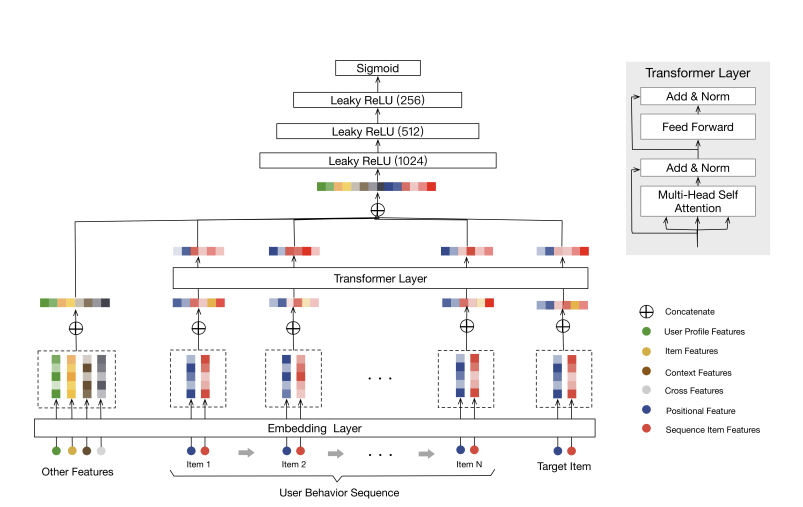

### 결과

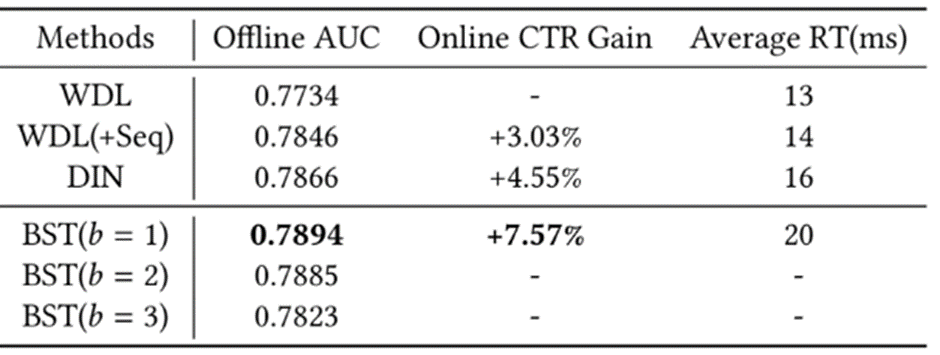
